In [57]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats("pdf", "svg")

from models.model import FluxLimiter
from utils import fvm_solver, utils

device = 'cpu'

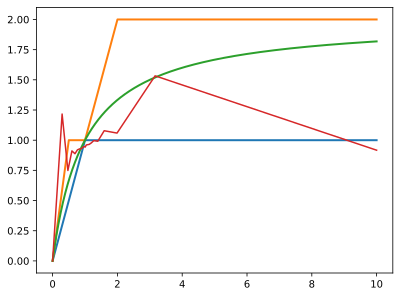

In [58]:
usePaperResult = True
phi0 = 0
jmax = 20


if usePaperResult:
    # Results from the paper (CG=2)
    deltarend = np.array([0, 0.37, 0.56, 0.68, 0.76, 0.82, 0.87, 0.91, 0.95, 0.98, 1.00, 1.04, 1.07, 1.13, 1.15, 1.21, 1.3, 1.44, 1.73, 2.58, 10])
    deltarbin = np.diff(deltarend)
    b = np.array([2.33, -1.68, 1.17, -0.22, 0.36, 0.03, 0.16, -0.02, 0.52, -0.23, 0.28, -0.15, 0.03, 0.09, 0.14, -0.04, 0.20, -0.08, 0.29, -0.09])
else:
    # Results from the github code
    deltarend = np.asarray([0.0, 0.30253194952516327, 0.48277227366200426, 0.6066641513244906, 0.700031889176244, 0.774349172794213, 0.8376738075866452, 0.8891835359827428, 0.9343650814531961, 0.9718869256408473, 1.0077618830671964, 1.043781845003239, 1.0823123870463447, 1.1281647964482964, 1.1875302598973254, 1.2682911419085794, 1.3868782283716778, 1.5829040560840966, 1.975149826717443, 3.1378916099638046, 10.0])
    deltarbin = np.diff(deltarend)
    b = np.asarray([4.099799736414207, -2.666356499523097, 1.4042731517691607, -0.22197021647866677, 0.21418594203427688, 0.2499149625372752, 0.30531152100212466, -0.00994034515315434, -0.3433565346766727, 1.0762798953525134, -0.8495828601834319, 0.5916867245616686, 0.2869297585804702, 0.5202489401078196, -0.18780576835715124, 0.10250581545746229, 0.045000059789416014, 0.18377754076991337, 0.3446348176554417, -0.08703296081262166])
    
    deltarend=np.asarray(
[0.0, 0.2935251969174088, 0.4723095173047612, 0.5960677208516134, 0.6901708294446358, 0.7670751974223374, 0.8319194875513409, 0.8873001385964494, 0.9324949058032356, 0.9707955058609764, 1.0055182965470055, 1.0406592364713834, 1.0808306780949801, 1.128997263935716, 1.189576041203444, 1.272994462863013, 1.3943803446620642, 1.5927263741453377, 1.9883132551567995, 3.163261690344454, 10.0]
    )
    deltarbin = np.diff(deltarend)
    b=np.asarray(
    [4.143590711678073, -2.6122203044467867, 1.3074638804494612, -0.24436308798371442, 0.41453820172134215, 0.12218874544203118, 0.0256119142411535, 0.24470534794801324, 0.18202625959384022, -0.1284609770187899, 0.5025623232500038, 0.05557783822064266, 0.046756902281742896, 0.18805215935901742, 0.24304646176614142, -0.045322956973436135, 0.4393136296491207, -0.04927991856519576, 0.4034122882211748, -0.09006779851116448]
)

def phiPWNONequalbin(b,xj,xltr,deltarbin,jmax,phi0):
    phi = 0.0
    if xj <= 0.0:
        phi = 0.0;
    elif xj > 0.0 + 1.0e-16 and xj <= xltr[jmax] + 1.0e-16:
        if xj <= xltr[1]:
            phi = b[0] * (xj - xltr[0]) + phi0
            if phi < 0.0:
                phi = 0.0
        else:
            for j in range(2,jmax+1):
                if xj <= xltr[j] and xj > xltr[j-1]:
                    phi = (b[:j-1] * deltarbin[:j-1]).sum()
                    phi = phi + b[j-1] * (xj - xltr[j-1]) + phi0
                    if phi < 0.0:
                        phi = 0.0
    else:
        for j in range(jmax):
            phi = phi + b[j] * deltarbin[j] + phi0
            if phi < 0.0:
                phi = 0.0
    return phi

def piecewise_linear_limiter(r):
    phi = np.zeros(len(r))
    for i in range(len(r)):
        phi[i] = phiPWNONequalbin(b=b,xj=r[i],xltr=deltarend,deltarbin=deltarbin,jmax=jmax,phi0=phi0)
    return phi


def plotPhiPW(ax):
    phi = np.zeros(jmax+1)
    for i in range(jmax+1):
        phi[i] = phiPWNONequalbin(b=b,xj=deltarend[i],xltr=deltarend,deltarbin=deltarbin,jmax=jmax,phi0=phi0)
    ax.plot(deltarend,phi)

fig, ax = plt.subplots()
r = np.linspace(0, 10, 1000)
ax.plot(r, utils.minmod(r), label="Minmod", lw=2, clip_on=False)
ax.plot(r, utils.superbee(r), label="Superbee", lw=2, clip_on=False)
ax.plot(r, utils.vanLeer(r), label="van Leer", lw=2, clip_on=False)
plotPhiPW(ax)

/Users/cyhuang/research/flux_limiter/src/utils/utils.py:20: RuntimeWarning: divide by zero encountered in divide
  r = (u - ul) / (ur - u)


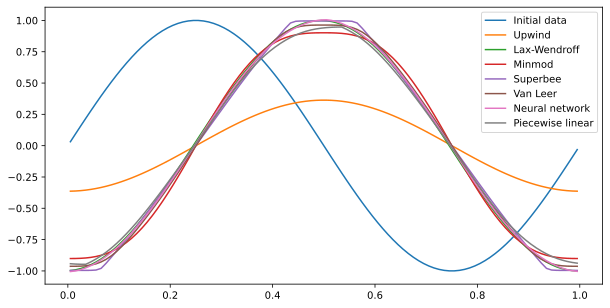

In [59]:
# Model
model = FluxLimiter(1,1,20,5,act="Tanh")
model.load_state_dict(torch.load("../model.pt"))
model = model.to(device)

def neural_flux_limiter(r):
    model.eval()
    with torch.no_grad():
        phi = model(torch.Tensor(r).view(-1, 1).to(device))
    return phi.numpy().squeeze()

x0, u0 = utils.sin_wave(N=100)
# x0, u0 = utils.square_wave(N=100)
# x0, u0 = utils.linear_spike(N=100)
# x0, u0 = utils.step(N=100)

flux_limiters = {
    "Upwind": utils.FOU,
    "Lax-Wendroff": utils.LaxWendroff,
    "Minmod": utils.minmod,
    "Superbee": utils.superbee,
    "Van Leer": utils.vanLeer,
    "Neural network": neural_flux_limiter,
    "Piecewise linear": piecewise_linear_limiter,
}

fig, ax = plt.subplots()
ax.plot(x0, u0, label='Initial data', clip_on=False)
for (name, flux_limiter) in flux_limiters.items():
    u, _ = fvm_solver.solve_linear_advection_1D(u0=u0, T=10.25, a=1., dx=x0[1]-x0[0], CFL=0.5, flux_limiter=flux_limiter)
    ax.plot(x0, u, label=name, clip_on=False)
ax.legend()
fig.set_size_inches(10,5)
plt.show()

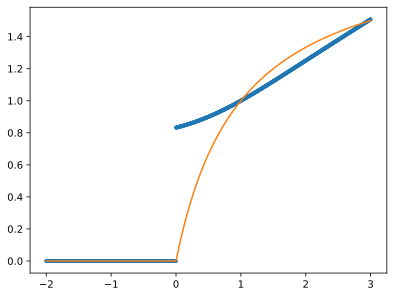

In [60]:
model.eval()
r_min = -2
r_max = 3
n_eval = 1000
r_eval = np.linspace(r_min, r_max, n_eval)
with torch.no_grad():
    preds = model(torch.Tensor(r_eval).view(-1,1))
fig, ax = plt.subplots()
ax.plot(r_eval, preds.cpu(), '.')
ax.plot(r_eval, utils.vanLeer(r_eval))
fig.savefig('learned_limiter_linear_case')